If you've worked with any kind of neural data, convolutions were involved at some point. Having an intuition for convolutions is quite useful in thinking about what your data actually is and what to do with it. This tutorial will cover some basic math and python code related to convolutions, with some specifics as to how these concepts are applied to neuoscience.

# Unconvoluting convolutions: an introduction and applications to neuroscience

Convolutions are pretty important operations for dealing with many kinds of data. Most simply, you can think of a convolution as a sliding window that performs some operation on your data. Imagine you have time-series data where the activation of a particular variable is $1$ between $t=-0.5$ and $t=0.5$, and is $0$ otherwise. This is indicated by the blue box below:

![](https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif "an example convolution")

*(from https://en.wikipedia.org/wiki/Convolution)*

The sliding red box corresponds to the convolution and the convolution operation (also called the filter). The black line is the result of the convolution. You can visualize this particular convolution as "spreading out" or "smoothing" your original data: instead of being strictly on and off, the convolved data ramps up to the maximum value and then ramps down, where the ramping up begins before the original data activation and the ramping down ends after the activation.

What's really happening is that the convolved data output at time $t$ is indicated by the weighted sum of the in the window, where the weights correspond to the convolution operation (can be called filter weights). In the above example, the red box is the filter such that everything in the box gets weighted by $1$ and summed, and the convolved output at time $t$ is the sum of those weighted values. 


## Defining convolutions

Informally, in order to do the "sliding window weighting" thing to get the output that we see above, we need to know four things:
1. <span style="color:LimeGreen">the current center of the window</span>
2. <span style="color:Goldenrod">the size of the window</span>
3. <span style="color:SteelBlue">what's currently in the window</span>
4. <span style="color:OrangeRed">how to weight the things in the window</span>

Let's specify these things. 

> -------------------------------------------------------------------------
> 
> Before formally defining a convolution, a reminder on what summation notation means:
> \begin{equation*}
> \sum_{t=0}^{T} f(t) = f(0) + f(1) + \ldots + f(T)
> \end{equation*}
> The $t=0$ at the bottom of the summation tells us that we start with $f(0)$, and the $T$ at the top tells us to stop at $f(T)$.
> 
> --------------------------------------------------------------------------

More formally, a discrete convolution (the kind most often done with data) can be defined as:
\begin{equation}
  ({\color{SteelBlue} f} * {\color{OrangeRed} g})({\color{LimeGreen} t}) = \sum_{\tau = {\color{Goldenrod} -T}}^{\color{Goldenrod} T} {\color{SteelBlue} f(t-\tau)} {\color{OrangeRed} g(\tau)}
\end{equation}
Where ${\color{LimeGreen} t}$ is the middle of the window, the values of $\tau = {\color{Goldenrod} {-T, -T+1, \ldots, -1, 0, 1, \ldots, T-1, T}}$ tell us the length of the window, the values ${\color{SteelBlue} f(t-\tau)}$ are the signal we wish to convolve over, and ${\color{OrangeRed} g(\tau)}$ defines the weights of the convolution filter. 

The discrete convolution equation tells us the things we need to know in order to do a convolution:
- The left side $({\color{SteelBlue} f} * {\color{OrangeRed} g})(t)$ is the output of the convolved signal at time $t$.
- The summation $\sum_{\tau=-T}^{T}$ tells us the size of the window around our current time $t$. The red window above would go from $-T=-1$ and $T=1$. 
- the function ${\color{SteelBlue} f(t-\tau)}$ can be considered to be the signal that is present in the filter window (between time $t-\tau$ to $t$). In the above example, ${\color{SteelBlue} f(t-\tau)} = 1$ if $-0.5 \leq t-\tau \leq 0.5$, and $0$ otherwise. 
- the function ${\color{OrangeRed} g(\tau)}$ is the convolution function or filter. Specifically, ${\color{OrangeRed} g(\tau)}$ tells us how to weight the data from ${\color{SteelBlue} f(t-\tau)}$. The red window above corresponds to ${\color{OrangeRed} g(\tau)} = 1$ if $-1 \leq \tau \leq 1$, and $0$ otherwise.
  - In other words, when your window overlaps with the data, the function ${\color{OrangeRed} g}$ tells us how we should re-weight the overlapping data.


> ---------------
> Aside: 
> The summation notation in this case is a bit confusing. Since the sum tells us to start at $\tau = -T$, and since the form of the convolution operation is $f(t-\tau)g(\tau)$ you can think of doing the summation from the back of the window to the front. To be explicit:
> \begin{align*}
>   (f*g)(t) &= \sum_{\tau=-T}^T f(t-\tau)g(\tau) \\
>   &= {\color{orange} f(t+T)g(-T)} + {\color{yellow} f(t+T-1)g(T-1)} + \ldots + f(t)g(0) + \ldots + {\color{green} f(t-T+1)g(T+1)} + {\color{Orchid} f(t-T)g(T)}
> \end{align*}
> 
> At first glance, this doesn't quite seem to make sense: why would you weight the value of your data at $f(t+T)$ by the value of the filter at $g(-T)$? One way to think about this is that the function $g$ is backwards relative to the sliding window visualization. This doesn't matter for filters that are symmetric around the center of the window, where $g(-\tau) = g(\tau)$ for all $\tau$. 
> 
> --------------

### What about the beginning?
You might be wondering what happens at $t=0$: how can we get $f(0-T) = f(-T)$? This is the issue where your window starts. The simplest solution is to just decrease the length of your data. If your data is total length $L$ the center of the window at the beginning will be at time $T$ and the center of the window after sliding across the data will be at time $L-T$. This way, you end up with convolved data that is length $L-2T$, as you could only start after time $T$ and end at time $L-T$. 

Now that we understand the basic form of a convolution, let's implement it in python! 

[Text(0.5, 1.0, 'discrete binary signal'),
 Text(0.5, 0, 'time'),
 Text(0, 0.5, 'variable activation')]

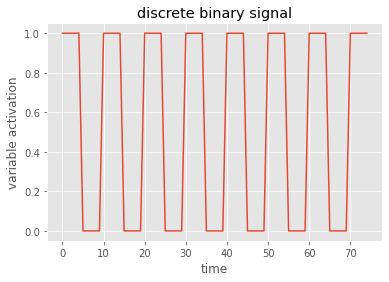

In [3]:
# implementing a 1d convolution in python
import time # for timing
import numpy as np # for manipulating arrays (vectors/matrices)
import matplotlib.pyplot as plt # for plotting
plt.style.use(['ggplot']) # nicer looking plots

# let's make up some data, similar to the box on/off activation above
n_phases = 5 # how many phases? (each phase is 1.5 activations)
activation_len = 5 # how long is each box?
time_between_activations = 10 # how much space between the boxes?
data = np.zeros((n_phases*(activation_len+time_between_activations)))
for i in range(activation_len):
    data[i::time_between_activations] = 1 # turn on the boxes

# plot the data - I always use the matplotlib axes objects
fig, ax = plt.subplots()
ax.plot(data)
ax.set(title='discrete binary signal', xlabel='time', ylabel='variable activation')

valid shape: (71,)
full shape: (79,)
same shape: (75,)


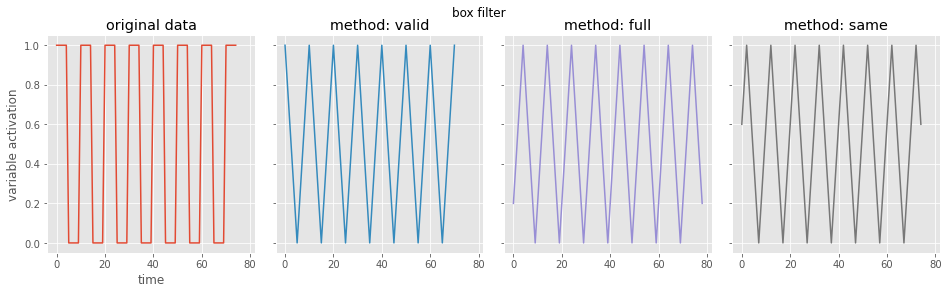

In [4]:
# let's look at the box filter
from scipy.signal import convolve # this is pretty fast

# first define convolution filter
filter_len = 5 # window is this long, assuming symmetric around 0
filter = np.ones((filter_len)) / filter_len # let's make this a box filter, like the gif above

# using the scipy library, let's look at the possible boundary conditions
boundary_settings = ['valid',  # only filter the data that's available
                     'full',   # extend data at boundaries to make output same shape as input
                     'same']   # extend data and be centered

# set up plots for the convolved data
fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
fig.suptitle('box filter')
ax=ax.flatten(order='F')
ax[0].plot(data)
ax[0].set(title='original data', xlabel='time', ylabel='variable activation')

# do each kind of convolution boundary
for i, curr_setting in enumerate(boundary_settings):
    conv_data = convolve(data, filter, curr_setting) # do the convolution
    print(curr_setting, 'shape: {}'.format(conv_data.shape)) # print the shape
    ax[i+1].plot(conv_data, color='C{}'.format(i+1))
    ax[i+1].set(title='method: {}'.format(curr_setting))

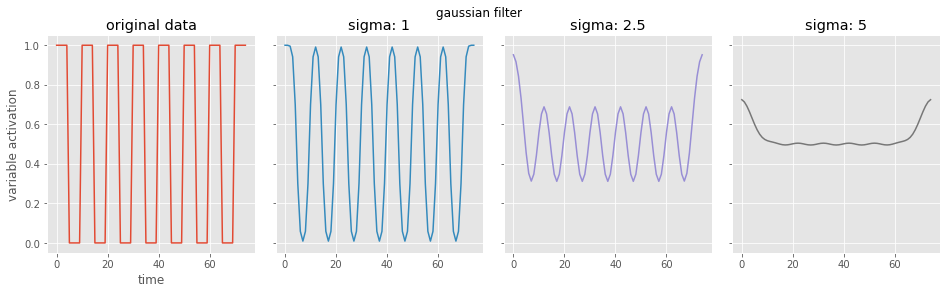

In [5]:
# now a gaussian filter
from scipy.ndimage import gaussian_filter1d

# look at a range of gaussian widths
sigs = [1, 2.5, 5]

fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
fig.suptitle('gaussian filter')
ax=ax.flatten(order='F')
ax[0].plot(data)
ax[0].set(title='original data', xlabel='time', ylabel='variable activation')

for i, currsig in enumerate(sigs):
    conv_data = gaussian_filter1d(data, sigma=currsig)
    ax[i+1].plot(conv_data, color='C{}'.format(i+1))
    ax[i+1].set(title='sigma: {}'.format(currsig))

### Convolving over multiple dimensions
We've looked convolving over 1-dimensional signals thus far. What if you have a 2-dimensional signal, like an image? Imagine doing the same exact thing of sliding the filter across the data, except now the filter has two dimensions. The same way of thinking about boundary settings also applies here: we could "pad" the original data (usually with $0$) all around the whole data:

![](https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif "2d convolution")        ![](https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif "2d padding")

*(from https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)*

#### The Gaussian blur
Instead of sliding a 1-dimensional Gaussian across a 1-dimensional signal, we can convolve a 2-dimensional gaussian across a 2-dimensional signal! A common preprocessing step for fMRI signals is to apply a 3-dimensional Gaussian blur to the BOLD activation values, which we can think of as smoothing the activations of the voxels relative to the neighboring voxels. [This useful resource](http://jpeelle.net/mri/image_processing/smoothing.html) gives some reasons of why we might want to smooth fMRI signals this way; note, however, that smoothing may actually hurt the performance of multi-voxel pattern analysis (MVPA).

To get an intuition for what a Gaussian blur does, let's apply it to some images in python. 

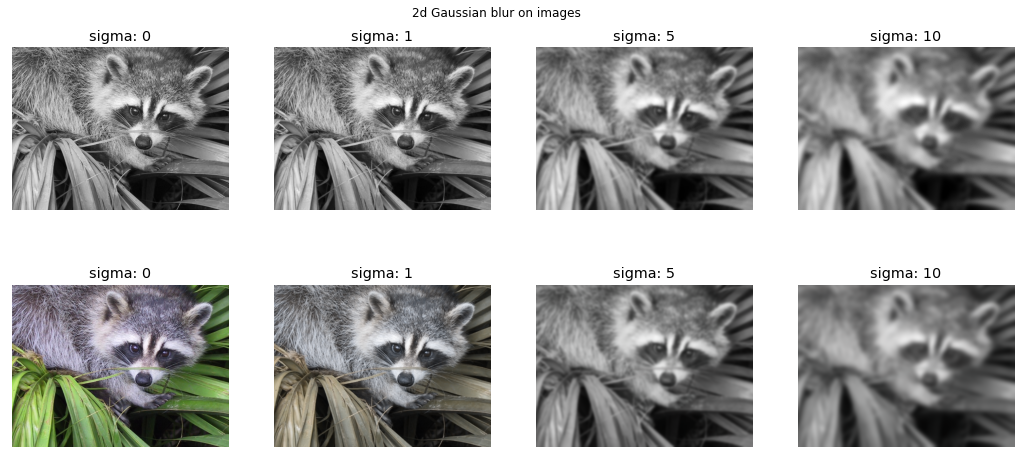

In [12]:
# 2d examples with images
from scipy.ndimage import gaussian_filter
from scipy.misc import face # for an image of a raccoon face

blur_sigs = [0, 1, 5, 10]

fig, ax = plt.subplots(2, 4, figsize=(18, 8), sharex=True, sharey=True)
fig.suptitle('2d Gaussian blur on images', y=.92)

for currcol, curr_sig in enumerate(blur_sigs):
    for currrow, isgray in enumerate([True, False]): # let's look at the effects on grey scale vs color images
        data = face(isgray) 
        conv_data = gaussian_filter(data, sigma=curr_sig)
        ax[currrow, currcol].imshow(conv_data, cmap='gray')
        ax[currrow, currcol].set(title='sigma: {}'.format(curr_sig), xticks=[], yticks=[])
        ax[currrow, currcol].grid(False) # the ggplot style has gridlines on images, let's take them off

## Deconvolutions

Let's go back to the 1-d discrete convolution, except now we'll explicitly relate everything to our data. First, let's call the output of a convolution ${\color{Orchid} h}$:

\begin{align*}
    {\color{Orchid} h(t)} = \sum_{\tau=-T}^{T} {\color{SteelBlue} f(t-\tau)} {\color{OrangeRed} g(\tau)}
\end{align*}
Remember that $-T$ and $T$ tell us the length of the window, ${\color{SteelBlue} f(t-\tau)}$ tells us what's in the window, ${\color{OrangeRed} g(\tau)}$ tells us how to weight the things in the window, and ${\color{Orchid} h(t)}$ is the convolved output at time $t$.

Let's say the data we collected is a 1-d timeseries called ${\color{grey} x(t)}$. We can think about putting ${\color{grey} x(t)}$ into the above equation at least two ways, both of which mean different things:

\begin{align*}
    {\color{Orchid} h(t)} &= \sum_{\tau=-T}^{T} {\color{grey} x(t-\tau)} {\color{OrangeRed} g(\tau)} \quad \substack{\text{the output }{\color{Orchid} h}\text{ is the result of a convolution} \\ \text{of our data }{\color{grey} x}\textrm{ with some filter or process }{\color{OrangeRed} g}}  \\
    {\color{grey} x(t)} &= \sum_{\tau=-T}^{T} {\color{SteelBlue} f(t-\tau)} {\color{OrangeRed} g(\tau)} \quad \substack{\textrm{our data }{\color{grey} x}\textrm{ is the result of a convolution of some} \\ \text{underlying signal }{\color{SteelBlue} f}\textrm{ with some filter or process }{\color{OrangeRed} g}} \\
\end{align*}

Often, we can think of this former situation as smoothing our data -- we're applying a convolution to it. We end up doing all our analyses on ${\color{Orchid} h}$; it is now the object of interest.

On the other hand, the latter situation says that the data is the result of an unobserved underlying process convolved with something. This is often the case with signals in neuroscience, as we often have measures of neural activity that are removed from the actual biological process we are interested in. (The situation is even more muddled, in fact, as the neural signals can then be used to model cognitive processes.) That is, fluorescent images or BOLD signals are just measures of neural activity (or even some other construct) convolved with the biological and engineering processes that go into producing and recording the data. 

This is exactly when we'd want to DEconvolve! In essence, deconvolution is basically applying the "inverse" filter: given our data ${\color{grey} x}$ and some knowledge of the filter ${\color{OrangeRed} g}$, how do we get the underlying signal ${\color{SteelBlue} f}$? In this context, ${\color{SteelBlue} f}$ is indeed the object of interest; we do our analyses on it, because we want to model the underlying signal, not the convolved signal. It's important to remember that we are able to do this to neural data by operationalizing the filter ${\color{OrangeRed} g}$ based on biological/engineering principles, as we will see below.

## Where do (de)convolutions come up in neuroscience?

Pretty much everywhere. (De)convolutions are used to preprocess and/or model every kind of data collected from a biological neural network (i.e., a brain). Beyond that, convolutions come up all the time when analyzing any kind of signal, because that's apparently just how signals are. In detail:

**Electrophysiological signals** 

Specifically, spikes. Spikes are often presented as time-stamps telling us when a neuron fired an action potential, or "spiked". Then, it is common to bin the spikes: we divide the total experiment time into bins of some small time -- anywhere from $5$ to $1000$ ms, depending on various things -- to get a matrix that is either $0$ (representing no spikes in that bin) or $1,2,3,\ldots$ (representing how many times that neuron spiked in that time bin). After this binning, it is pretty common to apply gaussian smoothing to the spike counts to get an estimate of that neuron's firing rate. If that doesn't make much sense to you, join the club. 
  
**Fluorescent signals** 

(i.e., from calcium imaging) rise and fall with spikes, but in a delayed and "diffused" manner relative to spikes. In other words, we can only detect changes in calcium concentration well after a spike has actually occurred. This can be viewed as the spiking signal being convolved with a "spike-to-calcium" smoothing filter. Since we record calcium signals, we need to apply the reverse "calcium-to-spike" unsmoothing filter, otherwise known as a deconvolution. 

**Blood Oxygenation Level Dependent (BOLD) signal** 

Data gathered in fMRI has a similar case of being measured with a delay relative to the neural activity in response to a stimulus; this is the nature of the signal. What we actually want is the stimulus information in neural activity -- we know this information must be there before we see the BOLD signal due to fast behavior, other neural measures, etc. 

What seems to be common is to model the BOLD signal as the result of convolving the Hemodynamic Response Function (HRF) to the presence of a hypothetical "impulse"; this impulse can be viewed as the presence of a stimulus, or the presence of the underlying neural activity related to that stimulus. From what I understand, the HRF is characterized by a ~6-second long delayed activation of BOLD signal relative to a stimulus onset; this seems to be consistent in some (?) regions and some (?) stimuli. 

In any case, we'd like to deconvolve to get from the BOLD signal to information about neural activity that is closer in time to the actual stimulus onset. One way to decode stimulus presence from BOLD signals seems to be to deconvolve the BOLD signal with the HRF. This animation illustrates these ideas: 

<img src="https://andysbrainbook.readthedocs.io/en/latest/_images/HRF_Demo.gif" alt="drawing" width="700"/>

*(from https://andysbrainbook.readthedocs.io/en/latest/fMRI_Short_Course/Statistics/03_Stats_HRF_Overview.html)*

## Convolutional Neural Networks (CNNs)
Deep neural networks are a class of models which can do some pretty cool things. If you want an intro to neural networks, [Miles had a great post - check it out!](https://dibsmethodsmeetings.github.io/nn-tutorial-dnm/) In short, a deep neural network looks something like this:

![](http://neuralnetworksanddeeplearning.com/images/tikz41.png "Fully connected")

Imagine you want to use a network like the one above to classify an image. How would you input the image into the network? One standard approach would be to "unfold" the image as a really long vector, and enter that vector into the network. This, among other things, prevents us from using some intuitive and important spatial relationships between pixels, such as translation invariance. That is, if a feature is present in the image, it could be present anywhere in the image and it would be the same feature; regular fully connected neural networks would have much trouble with this, while CNNs are basically built to find features that are invariant to such translations. 

A convolutional neural network (CNN) is a kind of neural network which gained a lot of attention by being better and faster than humans at various kinds of image classification around 10 years ago. Since then, they've only grown in numbers. Watch out. 

Here's what the convolution looks like:

----
![](http://neuralnetworksanddeeplearning.com/images/tikz44.png "CNN step one")

![](http://neuralnetworksanddeeplearning.com/images/tikz45.png "CNN step 2")

----
We do that for one filter, and get one matrix back. If we want to apply multiple filters (say, 3), we get 3 matrices back:

![](http://neuralnetworksanddeeplearning.com/images/tikz46.png "CNN step 2")

CNNs are so useful because we can automatically learn the filters that best describe the data in some way, using deep learning (a.k.a. neural network + stochastic gradient descent). An entire CNN looks something like this:

![](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png "typical CNN")

*(all convolution images from http://neuralnetworksanddeeplearning.com/chap6.html)*

### CNNs in neuroscience
As with many other fields across STEM and elsewhere, various forms of CNNs are and will continue to be important for making sense of high-dimensional data. As neural data, stimulus data, and behavioral data grow more complex, we can use CNNs to more or less automate the problem of finding a good convolution filter. The implication is that any place where convolutions are used to understand signals, CNNs could potentially be used to learn useful convolution filters from the data without (too much) human supervision. 

#### Are Brains $\simeq$ CNNs??
Because CNNs gained a lot of notoriety for being insanely good at image classification, and because they were kind of inspired by visual cortical responses[^0], a lot[^1] has been made[^2] about using CNNs as a model[^3] for how the visual system[^4] computes information, along with other areas[^5] of sensory cortex[^6]. This has certainly led to quite useful applications to retinal[^7] and auditory[^8] prosthetic devices, but it is (perhaps hotly) debated if a CNN model can offer us a useful way to organize what we know about neural computations. 

I could do a whole workshop on these ideas, but I'll just leave you with those references and this picture: 

<img src="../assets/images/2022-02-11-convolutions/conv_v1.png" alt="drawing" width="700"/>

*(From here [^3])*


[^0]: https://www.nature.com/articles/nature14539
[^1]: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006897
[^2]: https://proceedings.neurips.cc/paper/2016/hash/a1d33d0dfec820b41b54430b50e96b5c-Abstract.html
[^3]: https://arxiv.org/abs/2001.07092
[^4]: https://www.annualreviews.org/doi/abs/10.1146/annurev-vision-091718-014951
[^5]: https://www.sciencedirect.com/science/article/pii/S0896627318302502
[^6]: https://www.nature.com/articles/nn.4244
[^7]: https://www.nature.com/articles/s42256-020-00286-8
[^8]: https://www.sciencedirect.com/science/article/pii/S2095809920300357

